In [1]:
# test_stage1_setup.py
#
# Quick test to verify Stage 1 is working with your data

import torch
import numpy as np
from JAISP_dataset import make_loader
from stage1_jepa_foundation import JAISPFoundation

def test_data_loading(rubin_dir, euclid_dir):
    """Test data loader"""
    print("="*60)
    print("TESTING DATA LOADER")
    print("="*60)
    
    dataset, dataloader = make_loader(
        rubin_dir=rubin_dir,
        euclid_dir=euclid_dir,
        batch_size=2,
        shuffle=True,
        num_workers=0,  # Single thread for debugging
        persistent_workers=False
    )
    
    print(f"✓ Dataset loaded: {len(dataset)} tiles")
    
    # Get one batch
    batch = next(iter(dataloader))
    
    print(f"\n✓ Batch structure:")
    print(f"  x_rubin:  {len(batch['x_rubin'])} tiles")
    print(f"  x_euclid: {len(batch['x_euclid'])} tiles")
    
    for i in range(len(batch['x_rubin'])):
        print(f"\n  Tile {i}:")
        print(f"    Rubin:  {batch['x_rubin'][i].shape}")
        print(f"    Euclid: {batch['x_euclid'][i].shape}")
        print(f"    Rubin RMS:  {batch['rms_rubin'][i].shape}")
        print(f"    Euclid RMS: {batch['rms_euclid'][i].shape}")
        print(f"    Euclid mask: {batch['mask_euclid'][i]}")
    
    return batch


def test_patch_extraction(batch):
    """Test patch extraction"""
    print("\n" + "="*60)
    print("TESTING PATCH EXTRACTION")
    print("="*60)
    
    from stage1_jepa_foundation import PatchExtractor
    
    extractor = PatchExtractor(patch_size=128, n_patches=4)
    
    # Extract Rubin patches
    print("\nExtracting Rubin patches...")
    rubin_patches, rubin_weights = extractor(
        batch['x_rubin'], 
        batch['rms_rubin']
    )
    print(f"✓ Rubin patches: {rubin_patches.shape}")
    print(f"✓ Rubin weights: {rubin_weights.shape}")
    print(f"  Expected: ({len(batch['x_rubin']) * 4}, 6, 128, 128)")
    
    # Extract Euclid patches
    print("\nExtracting Euclid patches...")
    euclid_patches, euclid_weights = extractor(
        batch['x_euclid'], 
        batch['rms_euclid']
    )
    print(f"✓ Euclid patches: {euclid_patches.shape}")
    print(f"✓ Euclid weights: {euclid_weights.shape}")
    print(f"  Expected: ({len(batch['x_euclid']) * 4}, 4, 128, 128)")
    
    # Check for NaNs
    print("\nData quality checks:")
    print(f"  Rubin patches - finite: {torch.isfinite(rubin_patches).all()}")
    print(f"  Euclid patches - finite: {torch.isfinite(euclid_patches).all()}")
    print(f"  Rubin weights - finite: {torch.isfinite(rubin_weights).all()}")
    print(f"  Euclid weights - finite: {torch.isfinite(euclid_weights).all()}")
    
    # Statistics
    print("\nPatch statistics:")
    print(f"  Rubin mean:  {rubin_patches.mean():.4f}, std: {rubin_patches.std():.4f}")
    print(f"  Euclid mean: {euclid_patches.mean():.4f}, std: {euclid_patches.std():.4f}")
    
    return rubin_patches, rubin_weights, euclid_patches, euclid_weights


def test_encoder(patches, weights, encoder_type='rubin'):
    """Test encoder"""
    print("\n" + "="*60)
    print(f"TESTING {encoder_type.upper()} ENCODER")
    print("="*60)
    
    from stage1_jepa_foundation import ViTEncoder
    
    in_channels = 6 if encoder_type == 'rubin' else 4
    encoder = ViTEncoder(
        in_channels=in_channels,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6
    )
    
    print(f"Input shape: {patches.shape}")
    print(f"Weights shape: {weights.shape}")
    
    with torch.no_grad():
        features = encoder(patches, weights)
    
    print(f"✓ Output features: {features.shape}")
    print(f"  Expected: ({patches.shape[0]}, 384)")
    print(f"  Features finite: {torch.isfinite(features).all()}")
    print(f"  Features mean: {features.mean():.4f}, std: {features.std():.4f}")
    
    return features


def test_full_model(batch, device='cpu'):
    """Test full JEPA model"""
    print("\n" + "="*60)
    print("TESTING FULL JEPA MODEL")
    print("="*60)
    
    model = JAISPFoundation(
        patch_size=128,
        n_patches_per_tile=4,
        vit_patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6,
        projection_dim=256,
        temperature=0.07
    ).to(device)
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Model created")
    print(f"  Parameters: {n_params:,} ({n_params/1e6:.2f}M)")
    
    # Forward pass
    print("\nForward pass...")
    model.train()
    
    try:
        outputs = model(batch)
        
        print(f"✓ Forward pass successful!")
        print(f"\nOutputs:")
        print(f"  Loss: {outputs['loss'].item():.4f}")
        print(f"  z_rubin: {outputs['z_rubin'].shape}")
        print(f"  z_euclid: {outputs['z_euclid'].shape}")
        print(f"  z_rubin_raw: {outputs['z_rubin_raw'].shape}")
        print(f"  z_euclid_raw: {outputs['z_euclid_raw'].shape}")
        
        # Check embedding quality
        print("\nEmbedding quality:")
        similarity = torch.matmul(outputs['z_rubin'], outputs['z_euclid'].T)
        diag_sim = torch.diag(similarity).mean().item()
        off_diag = similarity.clone()
        off_diag.fill_diagonal_(0)
        off_diag_sim = off_diag.sum().item() / (similarity.numel() - similarity.shape[0])
        
        print(f"  Diagonal similarity (matched): {diag_sim:.4f}")
        print(f"  Off-diagonal similarity (unmatched): {off_diag_sim:.4f}")
        print(f"  Separation: {diag_sim - off_diag_sim:.4f}")
        print(f"    (Should increase during training)")
        
        # Test backward pass
        print("\nTesting backward pass...")
        outputs['loss'].backward()
        print("✓ Backward pass successful!")
        
        return True
        
    except Exception as e:
        print(f"✗ ERROR: {e}")
        import traceback
        traceback.print_exc()
        return False


def main():
    # CONFIGURE THESE PATHS
    RUBIN_DIR = "../data/rubin_tiles_ecdfs"   
    EUCLID_DIR = "../data/euclid_tiles_ecdfs" 
    
    print("\n" + "="*60)
    print("JAISP STAGE 1 - SETUP TEST")
    print("="*60)
    print(f"\nData directories:")
    print(f"  Rubin:  {RUBIN_DIR}")
    print(f"  Euclid: {EUCLID_DIR}")
    
    # Check device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print(f"\n✓ GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        print("\n⚠ No GPU detected - using CPU (will be slow)")
    
    try:
        # Test 1: Data loading
        batch = test_data_loading(RUBIN_DIR, EUCLID_DIR)
        
        # Test 2: Patch extraction
        rubin_patches, rubin_weights, euclid_patches, euclid_weights = test_patch_extraction(batch)
        
        # Test 3: Encoders
        rubin_features = test_encoder(rubin_patches, rubin_weights, 'rubin')
        euclid_features = test_encoder(euclid_patches, euclid_weights, 'euclid')
        
        # Test 4: Full model
        success = test_full_model(batch, device=device)
        
        if success:
            print("\n" + "="*60)
            print("✓ ALL TESTS PASSED!")
            print("="*60)
            print("\nYou're ready to train! Run:")
            print("  python train_stage1_foundation.py")
            print("\nRecommended settings for your data:")
            print("  - Batch size: 2-4 (depending on GPU memory)")
            print("  - Patch size: 128 (current)")
            print("  - Patches per tile: 4 (extracts 4 random crops per tile)")
            print("  - Total patches per batch: batch_size × 4")
        else:
            print("\n" + "="*60)
            print("✗ TESTS FAILED - check errors above")
            print("="*60)
    
    except Exception as e:
        print("\n" + "="*60)
        print("✗ FATAL ERROR")
        print("="*60)
        print(f"{e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()


JAISP STAGE 1 - SETUP TEST

Data directories:
  Rubin:  ../data/rubin_tiles_ecdfs
  Euclid: ../data/euclid_tiles_ecdfs

✓ GPU detected: Quadro RTX 6000
  Memory: 23.60 GB
TESTING DATA LOADER
✓ Dataset loaded: 144 tiles

✓ Batch structure:
  x_rubin:  2 tiles
  x_euclid: 2 tiles

  Tile 0:
    Rubin:  torch.Size([6, 512, 512])
    Euclid: torch.Size([4, 1050, 1050])
    Rubin RMS:  torch.Size([6, 512, 512])
    Euclid RMS: torch.Size([4, 1050, 1050])
    Euclid mask: tensor([1., 1., 1., 1.])

  Tile 1:
    Rubin:  torch.Size([6, 512, 512])
    Euclid: torch.Size([4, 1050, 1050])
    Rubin RMS:  torch.Size([6, 512, 512])
    Euclid RMS: torch.Size([4, 1050, 1050])
    Euclid mask: tensor([1., 1., 1., 1.])

TESTING PATCH EXTRACTION

Extracting Rubin patches...
✓ Rubin patches: torch.Size([8, 6, 128, 128])
✓ Rubin weights: torch.Size([8, 6, 128, 128])
  Expected: (8, 6, 128, 128)

Extracting Euclid patches...
✓ Euclid patches: torch.Size([8, 4, 128, 128])
✓ Euclid weights: torch.Size([8, 

TILE ALIGNMENT VERIFICATION

Checking source alignment...

Found 12 matched sources

Top 10 matches:
  #          Rubin (x,y)         Euclid (x,y)   Dist (pix)     Dist (")
--------------------------------------------------------------------------------
  1       (253.0, 416.0)       (260.5, 423.0)        10.26         2.05
  2       (414.0, 246.0)       (420.0, 252.5)         8.85         1.77
  3       (185.0, 111.0)       (191.5, 118.5)         9.92         1.98
  4       (172.0, 495.0)       (180.0, 502.0)        10.63         2.13
  5       (400.0, 209.0)       (406.0, 215.0)         8.49         1.70
  6       (381.0, 360.0)       (388.5, 366.5)         9.92         1.98
  7        (17.0, 257.0)        (25.0, 264.0)        10.63         2.13
  8       (143.0, 408.0)       (136.5, 407.5)         6.52         1.30
  9        (95.0, 504.0)        (95.5, 511.0)         7.02         1.40
 10       (442.0, 323.0)       (450.5, 328.5)        10.12         2.02

Alignment Statistics:
  M

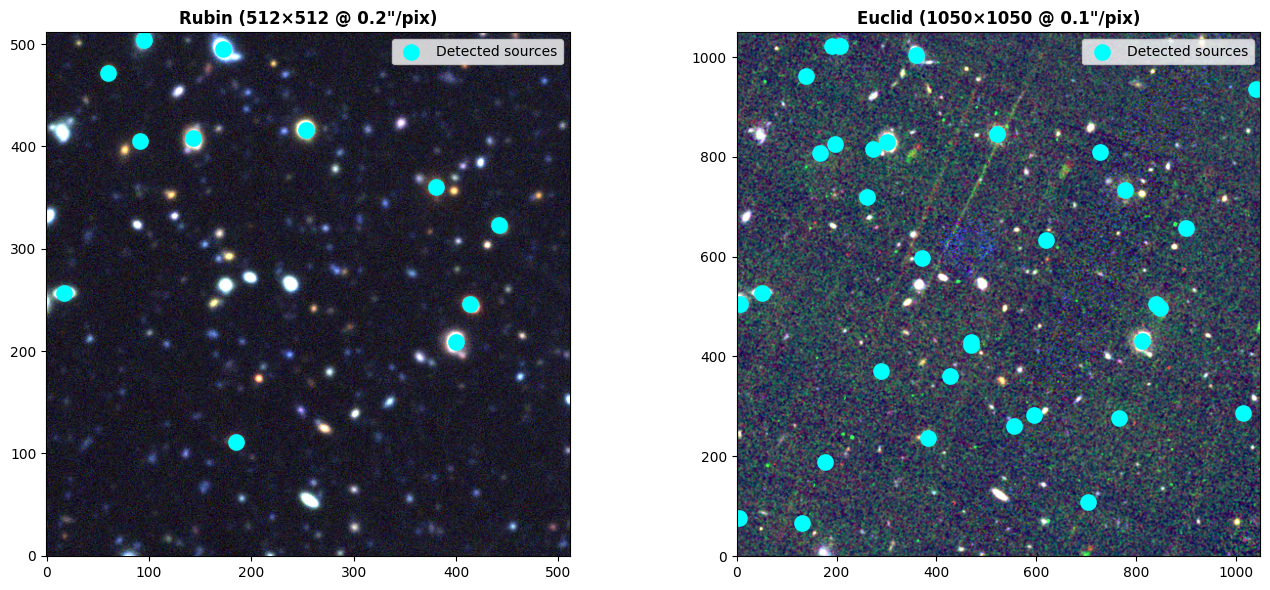


PATCH SIZE ANALYSIS

Tile sizes:
  Rubin:  512×512 pixels = 102.4"×102.4" on sky
  Euclid: 1050×1050 pixels = 105.0"×105.0" on sky

OLD patch sizes (MISMATCHED):
  Rubin:  128×128 = 25.6"×25.6"
  Euclid: 128×128 = 12.8"×12.8"  ← WRONG! Only half the sky area

NEW patch sizes (MATCHED):
  Rubin:  128×128 = 25.6"×25.6"
  Euclid: 256×256 = 25.6"×25.6"  ← CORRECT! Same sky area

Source density:
  Total sources detected: 12
  Expected per 25.6"×25.6" patch: ~0.8

⚠ WARNING: Very few sources per patch!
  → Consider larger patches (192×192 for Rubin, 384×384 for Euclid)


In [2]:
# verify_tile_alignment.py
#
# Verify that Rubin and Euclid tiles are actually aligned

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from JAISP_dataset import make_loader

def detect_sources(img, threshold_sigma=5):
    """Simple source detection: peaks above threshold"""
    # Take brightest band
    if img.ndim == 3:
        img = img.max(axis=0)  # Max across bands
    
    # Background estimation
    bg = np.nanmedian(img)
    noise = np.nanstd(img)
    
    # Detect peaks
    threshold = bg + threshold_sigma * noise
    local_max = maximum_filter(img, size=5) == img
    sources = (img > threshold) & local_max
    
    # Get coordinates
    y, x = np.where(sources)
    flux = img[sources]
    
    # Sort by brightness
    idx = np.argsort(flux)[::-1]
    
    return x[idx], y[idx], flux[idx]

def check_alignment(batch, tile_idx=0, n_sources=20):
    """Check if bright sources match between Rubin and Euclid"""
    
    rubin_img = batch['x_rubin'][tile_idx].numpy()
    euclid_img = batch['x_euclid'][tile_idx].numpy()
    
    # Detect sources
    r_x, r_y, r_flux = detect_sources(rubin_img)
    e_x, e_y, e_flux = detect_sources(euclid_img)
    
    # Pixel scales
    rubin_scale = 0.2  # arcsec/pixel
    euclid_scale = 0.1
    
    # Convert Euclid coordinates to Rubin frame
    # Assuming tiles are aligned, Euclid just has 2x sampling
    scale_ratio = euclid_scale / rubin_scale  # 0.5
    e_x_scaled = e_x * scale_ratio
    e_y_scaled = e_y * scale_ratio
    
    # Find nearest matches
    matches = []
    for i in range(min(n_sources, len(r_x))):
        # For each Rubin source, find nearest Euclid source
        dist = np.sqrt((e_x_scaled - r_x[i])**2 + (e_y_scaled - r_y[i])**2)
        if len(dist) > 0:
            nearest_idx = np.argmin(dist)
            nearest_dist = dist[nearest_idx]
            
            # Distance in arcsec
            dist_arcsec = nearest_dist * rubin_scale
            
            matches.append({
                'rubin_xy': (r_x[i], r_y[i]),
                'euclid_xy': (e_x_scaled[nearest_idx], e_y_scaled[nearest_idx]),
                'distance_pix': nearest_dist,
                'distance_arcsec': dist_arcsec,
                'rubin_flux': r_flux[i],
                'euclid_flux': e_flux[nearest_idx]
            })
    
    return matches

def visualize_alignment(batch, tile_idx=0):
    """Visualize Rubin and Euclid images with detected sources"""
    
    rubin_img = batch['x_rubin'][tile_idx].numpy()
    euclid_img = batch['x_euclid'][tile_idx].numpy()
    
    # Detect sources
    r_x, r_y, r_flux = detect_sources(rubin_img)
    e_x, e_y, e_flux = detect_sources(euclid_img)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Rubin
    ax = axes[0]
    rubin_rgb = np.stack([
        rubin_img[3],  # i-band → red
        rubin_img[2],  # r-band → green  
        rubin_img[1]   # g-band → blue
    ], axis=-1)
    # Normalize
    for i in range(3):
        p1, p99 = np.nanpercentile(rubin_rgb[..., i], [1, 99])
        rubin_rgb[..., i] = np.clip((rubin_rgb[..., i] - p1) / (p99 - p1), 0, 1)
    
    ax.imshow(rubin_rgb, origin='lower')
    ax.scatter(r_x[:50], r_y[:50], c='cyan', s=100, marker='o', 
              facecolors='none', linewidths=2, label='Detected sources')
    ax.set_title('Rubin (512×512 @ 0.2"/pix)', fontsize=12, weight='bold')
    ax.legend()
    
    # Euclid
    ax = axes[1]
    euclid_rgb = np.stack([
        euclid_img[2],  # J-band → red
        euclid_img[1],  # Y-band → green
        euclid_img[0]   # VIS-band → blue
    ], axis=-1)
    # Normalize
    for i in range(3):
        p1, p99 = np.nanpercentile(euclid_rgb[..., i], [1, 99])
        euclid_rgb[..., i] = np.clip((euclid_rgb[..., i] - p1) / (p99 - p1), 0, 1)
    
    ax.imshow(euclid_rgb, origin='lower')
    ax.scatter(e_x[:50], e_y[:50], c='cyan', s=100, marker='o',
              facecolors='none', linewidths=2, label='Detected sources')
    ax.set_title('Euclid (1050×1050 @ 0.1"/pix)', fontsize=12, weight='bold')
    ax.legend()
    
    plt.tight_layout()
    return fig

def main():
    RUBIN_DIR = "../data/rubin_tiles_ecdfs"
    EUCLID_DIR = "../data/euclid_tiles_ecdfs"
    
    print("="*60)
    print("TILE ALIGNMENT VERIFICATION")
    print("="*60)
    
    # Load data
    _, dataloader = make_loader(
        rubin_dir=RUBIN_DIR,
        euclid_dir=EUCLID_DIR,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    
    batch = next(iter(dataloader))
    
    # Check alignment
    print("\nChecking source alignment...")
    matches = check_alignment(batch, tile_idx=0, n_sources=20)
    
    print(f"\nFound {len(matches)} matched sources")
    print("\nTop 10 matches:")
    dist_arcsec_label = 'Dist (")'
    print(f"{'#':>3} {'Rubin (x,y)':>20} {'Euclid (x,y)':>20} {'Dist (pix)':>12} {dist_arcsec_label:>12}")
    print("-" * 80)
    
    for i, m in enumerate(matches[:10]):
        r_xy = f"({m['rubin_xy'][0]:.1f}, {m['rubin_xy'][1]:.1f})"
        e_xy = f"({m['euclid_xy'][0]:.1f}, {m['euclid_xy'][1]:.1f})"
        print(f"{i+1:3d} {r_xy:>20} {e_xy:>20} {m['distance_pix']:12.2f} {m['distance_arcsec']:12.2f}")
    
    # Statistics
    distances = [m['distance_arcsec'] for m in matches]
    median_dist = np.median(distances)
    rms_dist = np.sqrt(np.mean(np.array(distances)**2))
    
    arcsec = '"'
    print(f"\nAlignment Statistics:")
    print(f"  Median distance: {median_dist:.3f}{arcsec}")
    print(f"  RMS distance:    {rms_dist:.3f}{arcsec}")
    print(f"  Max distance:    {np.max(distances):.3f}{arcsec}")
    
    if median_dist < 0.5:
        print(f"\n✓ GOOD: Tiles appear well-aligned (<0.5{arcsec} median offset)")
    elif median_dist < 1.0:
        print(f"\n⚠ FAIR: Some misalignment detected (~1{arcsec} median offset)")
    else:
        print(f"\n✗ BAD: Significant misalignment (>1{arcsec} median offset)")
        print("  → This will hurt contrastive learning!")
    
    # Visualize
    print("\nGenerating visualization...")
    fig = visualize_alignment(batch, tile_idx=0)
    #plt.savefig('tile_alignment_check.png', dpi=200, bbox_inches='tight')
    print("Saved: tile_alignment_check.png")
    plt.show()
    
    print("\n" + "="*60)
    print("PATCH SIZE ANALYSIS")
    print("="*60)
    
    rubin_shape = batch['x_rubin'][0].shape[-2:]
    euclid_shape = batch['x_euclid'][0].shape[-2:]
    
    arcsec = '"'
    print(f"\nTile sizes:")
    print(f"  Rubin:  {rubin_shape[0]}×{rubin_shape[1]} pixels = {rubin_shape[0]*0.2:.1f}{arcsec}×{rubin_shape[1]*0.2:.1f}{arcsec} on sky")
    print(f"  Euclid: {euclid_shape[0]}×{euclid_shape[1]} pixels = {euclid_shape[0]*0.1:.1f}{arcsec}×{euclid_shape[1]*0.1:.1f}{arcsec} on sky")
    
    print(f"\nOLD patch sizes (MISMATCHED):")
    print(f"  Rubin:  128×128 = 25.6{arcsec}×25.6{arcsec}")
    print(f"  Euclid: 128×128 = 12.8{arcsec}×12.8{arcsec}  ← WRONG! Only half the sky area")
    
    print(f"\nNEW patch sizes (MATCHED):")
    print(f"  Rubin:  128×128 = 25.6{arcsec}×25.6{arcsec}")
    print(f"  Euclid: 256×256 = 25.6{arcsec}×25.6{arcsec}  ← CORRECT! Same sky area")
    
    # Estimate sources per patch
    r_x, r_y, r_flux = detect_sources(batch['x_rubin'][0].numpy())
    sources_per_tile = len(r_x)
    tile_area = (rubin_shape[0] * 0.2) * (rubin_shape[1] * 0.2)  # arcsec^2
    patch_area = 25.6 * 25.6
    
    expected_sources = sources_per_tile * (patch_area / tile_area)
    
    arcsec = '"'
    print(f"\nSource density:")
    print(f"  Total sources detected: {sources_per_tile}")
    print(f"  Expected per 25.6{arcsec}×25.6{arcsec} patch: ~{expected_sources:.1f}")
    
    if expected_sources < 3:
        print("\n⚠ WARNING: Very few sources per patch!")
        print("  → Consider larger patches (192×192 for Rubin, 384×384 for Euclid)")
    elif expected_sources > 20:
        print("\n✓ GOOD: Enough sources for meaningful comparison")
    else:
        print("\n✓ OK: Moderate number of sources per patch")

if __name__ == "__main__":
    main()

SOURCE DENSITY ANALYSIS

Analyzing 20 tiles with patch size:
  Rubin:  192×192 = 38.4"×38.4"
  Euclid: 384×384 = 38.4"×38.4"

RESULTS: Sources per patch

Peaks (≥3σ):
  Mean:   1222.6 ± 360.3
  Median: 1374
  Range:  43 - 1474

Peaks (≥5σ):
  Mean:   719.9 ± 329.2
  Median: 841
  Range:  13 - 1163

Peaks (≥10σ):
  Mean:   31.0 ± 18.2
  Median: 28
  Range:  3 - 96

Connected regions (≥3σ):
  Mean:   130.9 ± 64.2
  Median: 142
  Range:  3 - 290

✓ Saved: source_density_analysis.png


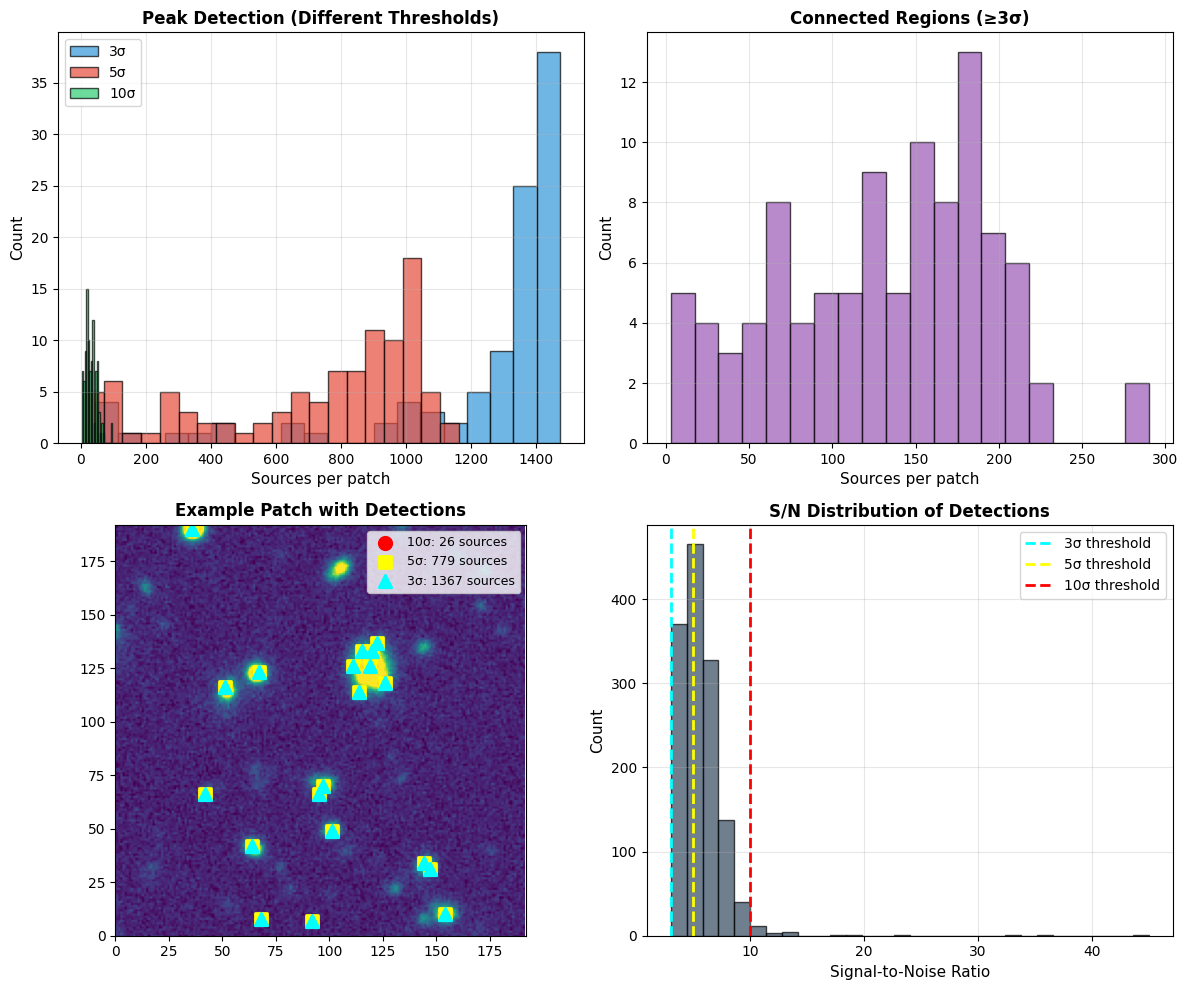


RECOMMENDATION

Best estimate: ~130.9 sources per patch
  (Using connected regions at 3σ threshold)

✓ GOOD: Plenty of sources for matching!


In [4]:
# count_sources_proper.py
#
# Better source counting with multiple S/N thresholds

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, label
from JAISP_dataset import make_loader


def detect_sources_multi_threshold(img, snr_thresholds=[3, 5, 10]):
    """
    Detect sources at multiple S/N thresholds.
    Returns counts and positions for each threshold.
    """
    # Use brightest band
    if img.ndim == 3:
        img = img.max(axis=0)
    
    # Robust background estimation (avoiding bright sources)
    bg = np.nanpercentile(img, 50)  # median
    # Use MAD for robust noise estimate
    mad = np.nanmedian(np.abs(img - bg))
    noise = 1.4826 * mad  # Convert MAD to std
    
    results = {}
    
    for snr in snr_thresholds:
        threshold = bg + snr * noise
        
        # Find local maxima above threshold
        local_max = maximum_filter(img, size=5) == img
        detections = (img > threshold) & local_max & np.isfinite(img)
        
        # Get positions
        y, x = np.where(detections)
        flux = img[detections]
        
        # Sort by brightness
        idx = np.argsort(flux)[::-1]
        
        results[snr] = {
            'count': len(x),
            'x': x[idx],
            'y': y[idx],
            'flux': flux[idx],
            'snr_values': (flux[idx] - bg) / noise
        }
    
    return results, bg, noise


def estimate_connected_sources(img, snr_threshold=3):
    """
    Count connected regions above threshold (better for extended sources).
    """
    if img.ndim == 3:
        img = img.max(axis=0)
    
    bg = np.nanpercentile(img, 50)
    mad = np.nanmedian(np.abs(img - bg))
    noise = 1.4826 * mad
    
    threshold = bg + snr_threshold * noise
    mask = (img > threshold) & np.isfinite(img)
    
    # Label connected regions
    labeled, n_sources = label(mask)
    
    # Filter out small noise blobs (< 4 pixels)
    sizes = np.bincount(labeled.ravel())
    sizes[0] = 0  # Ignore background
    valid_labels = np.where(sizes >= 4)[0]
    
    return len(valid_labels) - 1  # -1 to exclude background label


def analyze_patch_source_density(rubin_dir, euclid_dir, 
                                 patch_size_rubin=192,
                                 patch_size_euclid=384,
                                 n_tiles=20):
    """
    Analyze how many sources are in patches of given size.
    """
    _, dataloader = make_loader(
        rubin_dir=rubin_dir,
        euclid_dir=euclid_dir,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    
    print("="*70)
    print("SOURCE DENSITY ANALYSIS")
    print("="*70)
    
    # Sample patches
    all_counts = {3: [], 5: [], 10: [], 'connected_3': []}
    
    print(f"\nAnalyzing {n_tiles} tiles with patch size:")
    print(f"  Rubin:  {patch_size_rubin}×{patch_size_rubin} = {patch_size_rubin*0.2:.1f}\"×{patch_size_rubin*0.2:.1f}\"")
    print(f"  Euclid: {patch_size_euclid}×{patch_size_euclid} = {patch_size_euclid*0.1:.1f}\"×{patch_size_euclid*0.1:.1f}\"")
    
    for i, batch in enumerate(dataloader):
        if i >= n_tiles:
            break
        
        rubin_img = batch['x_rubin'][0].numpy()
        H, W = rubin_img.shape[-2:]
        
        # Extract random patches (simulate training)
        n_patches = 5
        for _ in range(n_patches):
            if H >= patch_size_rubin and W >= patch_size_rubin:
                y = np.random.randint(0, H - patch_size_rubin + 1)
                x = np.random.randint(0, W - patch_size_rubin + 1)
                
                patch = rubin_img[:, y:y+patch_size_rubin, x:x+patch_size_rubin]
                
                # Peak detection at multiple thresholds
                results, bg, noise = detect_sources_multi_threshold(patch, [3, 5, 10])
                all_counts[3].append(results[3]['count'])
                all_counts[5].append(results[5]['count'])
                all_counts[10].append(results[10]['count'])
                
                # Connected regions
                n_connected = estimate_connected_sources(patch, snr_threshold=3)
                all_counts['connected_3'].append(n_connected)
    
    # Print statistics
    print("\n" + "="*70)
    print("RESULTS: Sources per patch")
    print("="*70)
    
    for method, counts in all_counts.items():
        if len(counts) == 0:
            continue
        
        mean_count = np.mean(counts)
        median_count = np.median(counts)
        std_count = np.std(counts)
        
        if method == 'connected_3':
            label = "Connected regions (≥3σ)"
        else:
            label = f"Peaks (≥{method}σ)"
        
        print(f"\n{label}:")
        print(f"  Mean:   {mean_count:.1f} ± {std_count:.1f}")
        print(f"  Median: {median_count:.0f}")
        print(f"  Range:  {np.min(counts):.0f} - {np.max(counts):.0f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Histograms
    ax = axes[0, 0]
    ax.hist(all_counts[3], bins=20, alpha=0.7, label='3σ', color='#3498DB', edgecolor='black')
    ax.hist(all_counts[5], bins=20, alpha=0.7, label='5σ', color='#E74C3C', edgecolor='black')
    ax.hist(all_counts[10], bins=20, alpha=0.7, label='10σ', color='#2ECC71', edgecolor='black')
    ax.set_xlabel('Sources per patch', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Peak Detection (Different Thresholds)', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Connected regions
    ax = axes[0, 1]
    ax.hist(all_counts['connected_3'], bins=20, alpha=0.7, color='#9B59B6', edgecolor='black')
    ax.set_xlabel('Sources per patch', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Connected Regions (≥3σ)', fontsize=12, weight='bold')
    ax.grid(alpha=0.3)
    
    # Example patch with detections
    batch = next(iter(dataloader))
    rubin_img = batch['x_rubin'][0].numpy()
    H, W = rubin_img.shape[-2:]
    y = np.random.randint(0, H - patch_size_rubin + 1)
    x = np.random.randint(0, W - patch_size_rubin + 1)
    patch = rubin_img[:, y:y+patch_size_rubin, x:x+patch_size_rubin]
    
    results, bg, noise = detect_sources_multi_threshold(patch, [3, 5, 10])
    
    # Show patch
    ax = axes[1, 0]
    display_img = patch[3]  # i-band
    vmin, vmax = np.nanpercentile(display_img, [1, 99])
    ax.imshow(display_img, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    
    # Overlay detections
    for snr, color, marker in [(10, 'red', 'o'), (5, 'yellow', 's'), (3, 'cyan', '^')]:
        r = results[snr]
        if r['count'] > 0:
            ax.scatter(r['x'][:20], r['y'][:20], c=color, s=80, 
                      marker=marker, facecolors='none', linewidths=2,
                      label=f"{snr}σ: {r['count']} sources")
    
    ax.set_title('Example Patch with Detections', fontsize=12, weight='bold')
    ax.legend(fontsize=9)
    ax.set_xlim(0, patch_size_rubin)
    ax.set_ylim(0, patch_size_rubin)
    
    # S/N distribution
    ax = axes[1, 1]
    snr_values = results[3]['snr_values']
    if len(snr_values) > 0:
        ax.hist(snr_values, bins=30, alpha=0.7, color='#34495E', edgecolor='black')
        ax.axvline(3, color='cyan', linestyle='--', linewidth=2, label='3σ threshold')
        ax.axvline(5, color='yellow', linestyle='--', linewidth=2, label='5σ threshold')
        ax.axvline(10, color='red', linestyle='--', linewidth=2, label='10σ threshold')
        ax.set_xlabel('Signal-to-Noise Ratio', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title('S/N Distribution of Detections', fontsize=12, weight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    #plt.savefig('source_density_analysis.png', dpi=200, bbox_inches='tight')
    print("\n✓ Saved: source_density_analysis.png")
    plt.show()
    
    # Recommendation
    print("\n" + "="*70)
    print("RECOMMENDATION")
    print("="*70)
    
    mean_3sigma = np.mean(all_counts[3])
    mean_connected = np.mean(all_counts['connected_3'])
    
    print(f"\nBest estimate: ~{mean_connected:.1f} sources per patch")
    print(f"  (Using connected regions at 3σ threshold)")
    
    if mean_connected < 2:
        print("\n⚠ WARNING: Very few sources!")
        print("  Consider:")
        print(f"    - Larger patches (256×256 Rubin, 512×512 Euclid)")
        print(f"    - Or accept that learning will be from large-scale structure")
    elif mean_connected < 5:
        print("\n✓ OK: Moderate source density")
        print("  Should be enough for contrastive learning")
    else:
        print("\n✓ GOOD: Plenty of sources for matching!")


def main():
    RUBIN_DIR = "../data/rubin_tiles_ecdfs"
    EUCLID_DIR = "../data/euclid_tiles_ecdfs"
    
    analyze_patch_source_density(
        rubin_dir=RUBIN_DIR,
        euclid_dir=EUCLID_DIR,
        patch_size_rubin=192,
        patch_size_euclid=384,
        n_tiles=20
    )


if __name__ == "__main__":
    main()